# Filter format conversion

Most filters are from SVO. Where theses are not available or we have superior options they may be in different formats and need converting or checking. This notebook is converts filters in non votable form to votable format.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [22]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import seaborn.apionly as sns

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import ascii
from astropy.io.votable.tree import VOTableFile, Resource, Field
from astropy.io.votable import from_table, writeto

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

#filters_folder = "/Users/rs548/GitHub/herschelhelp_python/database_builder/format_changing/"

## Mosaic Ks

In [4]:
mosaic_ks = ascii.read('./format_changing/mosaic_ks.txt')

In [5]:
mosaic_ks[:10]

col1,col2
float64,float64
1.9,0.0
1.91,0.005
1.92,0.015
1.93,0.05
1.94,0.16
1.95,0.55
1.96,0.91
1.97,0.95
1.98,0.96


In [6]:
mosaic_ks['col1'].name = 'Wavelength'
# Convert units to angstroms
mosaic_ks['Wavelength'] = mosaic_ks['Wavelength']*1.e4
mosaic_ks['Wavelength'].unit = u.angstrom
mosaic_ks['col2'].name = 'Transmission'
mosaic_ks.meta["Description"] = 'Ks Mosaic'
mosaic_ks.meta["Band"] = 'Ks'
mosaic_ks.meta["Facility"] = 'KPNO'
mosaic_ks.meta["Instrument"] = 'Mosaic'
# Required meta

In [7]:
mosaic_ks[:10]

Wavelength,Transmission
Angstrom,
float64,float64
19000.0,0.0
19100.0,0.005
19200.0,0.015
19300.0,0.05
19400.0,0.16
19500.0,0.55
19600.0,0.91
19700.0,0.95


In [8]:
writeto(mosaic_ks, './filters/mosaic_ks.xml')

In [9]:
mosaic_b = ascii.read('./format_changing/mosaic_b.dat')
mosaic_b['col1'].name = 'Wavelength'
mosaic_b['Wavelength'].unit = u.angstrom
mosaic_b['col2'].name = 'Transmission'
#Convert percent to fraction
mosaic_b['Transmission'] = mosaic_b['Transmission']*1.e-2
#mosaic_b
mosaic_b.meta["Description"] = 'Bw Mosaic k1025'
mosaic_b.meta["Band"] = 'Bw'
mosaic_b.meta["Facility"] = 'KPNO'
mosaic_b.meta["Instrument"] = 'Mosaic'

In [10]:
mosaic_b[:10]

Wavelength,Transmission
Angstrom,
float64,float64
3200.0,-0.0001
3202.0,-0.00015
3204.0,-5e-05
3206.0,0.0001
3208.0,-0.0001
3210.0,-0.00015
3212.0,-0.0001
3214.0,-0.0002


In [11]:
writeto(mosaic_b, './filters/mosaic_b.xml')

## Suprime narrow

Filters downloaded from http://cosmos.astro.caltech.edu/page/filterset

For some reason teh same filter is sometimes always labelled IB and sometimes ia or ib. We follow the convention in the COSMOS2015 paper.

|name in COSMOS2015| name in HELP    | Name on download page |
|:-----------------|:----------------|:----------------------|
| ia484            | suprime_ia484   | IB484                 |
| ia527            | suprime_ia527   | IB527                 |
| ia624            | suprime_ia624   | IB624                 |
| ia679            | suprime_ia679   | IB679                 |
| ia738            | suprime_ia738   | IB738                 |
| ia767            | suprime_ia767   | IB767                 |
| ib427            | suprime_ib427   | IB427                 |
| ib464            | suprime_ib464   | IB464                 |
| ib505            | suprime_ib505   | IB505                 |
| ib574            | suprime_ib574   | IB574                 |
| ib709            | suprime_ib709   | IB709                 |
| ib827            | suprime_ib827   | IB827                 |

In [12]:
suprime_filters = [
    'ia484',
    'ia527',
    'ia624',
    'ia679',
    'ia738',
    'ia767',
    'ib427',
    'ib464',
    'ib505',
    'ib574',
    'ib709',
    'ib827'
]


In [13]:
sup_test = ascii.read('./format_changing/IB427.SuprimeCam.pb')
sup_test[:10].show_in_notebook()
sup_test.meta

OrderedDict([('comments',
              ['filter: IB427',
               'instrument: SuprimeCam',
               'description: Telescope + CCD + filter + atmosphere',
               'reference: None',
               'comment: Filter Passband from S. Sasaki web page, file IB3_07.txt',
               'comment: CCD and Optics transmission derived from the filter curves',
               'comment: at http://indus.astron.s.u-tokyo.ac.jp/works/suprime/filters/',
               'comment: Litterature inband flux at 0 mag and bandwidth computed from bandpass',
               'comment: Prepared by H. Aussel (herve dot aussel at cea dot fr)',
               'url: http://cosmos.phys.sci.ehime-u.ac.jp/~sasaki/NB+IA_FILTER/filter.html',
               'system: ab',
               'primary standard: abstd',
               'primary magnitude: 0.0',
               'bandwidth (xunit): 195.80568365897',
               'inband flux at 0 mag: 1.17279863299192E-09',
               'airmass: 1.2',
          

In [16]:
for f in suprime_filters:
    tab = ascii.read('./format_changing/{}.SuprimeCam.pb'.format(f.upper()))
    tab['file:'].name = 'Wavelength'
    tab['Wavelength'].unit = u.angstrom
    tab['{}.SuprimeCam.pb'.format(f.replace('a','b').upper())].name = 'Transmission'
    tab.meta["Description"] = 'Suprime {}'.format(f)
    tab.meta["Band"] = f
    tab.meta["Facility"] = 'Subaru'
    writeto(tab, './filters/suprime_{}.xml'.format(f.lower()))

For Suprime zp we have teh option of using the SVO one and doubling it or taking the download and converting. 

In [36]:
suprime_zp = ascii.read('./format_changing/suprime_zp.res')
suprime_zp['col1'].name = 'Wavelength'
suprime_zp['Wavelength'].unit = u.angstrom
suprime_zp['col2'].name = 'Transmission'
#Use over SVO doubles?
writeto(tab, './filters/suprime_zp.xml')

In [37]:
suprime_zpp = ascii.read('./format_changing/suprime_zpp.res')
suprime_zpp['col1'].name = 'Wavelength'
suprime_zpp['Wavelength'].unit = u.angstrom
suprime_zpp['col2'].name = 'Transmission'
#Use over SVO doubles?
writeto(tab, './filters/suprime_zp.xml')

In [39]:
svo_suprime_zp = Table(data = parse_single_table('./format_changing/SVO_suprime_zp.xml').array.data)

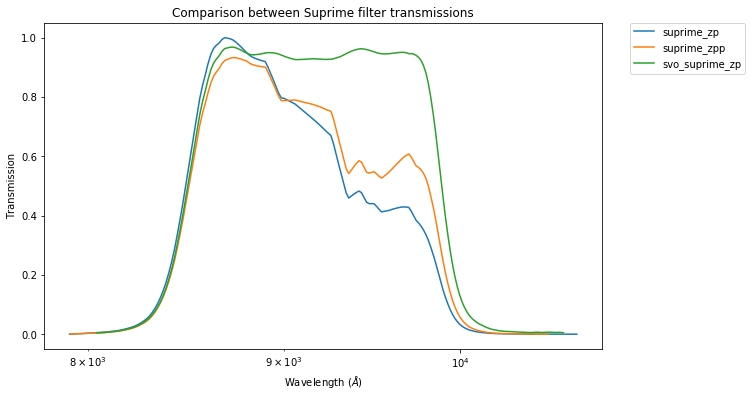

In [40]:
plt.plot(suprime_zp['Wavelength'],suprime_zp['Transmission'], label='suprime_zp')

plt.plot(suprime_zpp['Wavelength'],suprime_zpp['Transmission'], label='suprime_zpp')

plt.plot(svo_suprime_zp['Wavelength'],svo_suprime_zp['Transmission'], label='svo_suprime_zp')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison between Suprime filter transmissions')

It looks like the SVO filters don't include atmospheric correction so we use the downloaded conversions

### Hawaii QUIRC instrument HK

In [41]:
quirc_hk = ascii.read('./format_changing/quirc_hk.txt')
quirc_hk['col1'].name = 'Wavelength'
quirc_hk['Wavelength'] *= 10000.
quirc_hk['Wavelength'].unit = u.angstrom
quirc_hk['col2'].name = 'Transmission'



In [42]:
quirc_hk['Wavelength'][:10]

13900.0
14000.0
14100.0
14200.0
14300.0
14400.0
14500.0
14600.0
14700.0
14800.0


In [43]:
writeto(tab, './filters/quirc_hk.xml')